# Modeling the ENSO Phenomenon Through the Multivariate ENSO Index with ARMA/ARIMA Models

## Introduction
"El Niño and La Niña, together called the El Niño Southern Oscillation (ENSO), are episodic departures from expected sea surface temperatures (SSTs) in the equatorial Pacific Ocean." [1](https://psl.noaa.gov/enso/)

The Multivariate ENSO Index (MEI) utilizes oceanic and atmospheric variables to provide a quantifiable value for the intensity of the ENSO phenomenon in real time. The MEI is measured in overlapping bimonthly periods, considering periods such as January-February, February-March, March-April, and so on. This index incorporates the following variables:

Sea Level Pressure (SLP)
Sea Surface Temperature (SST)
Outgoing Longwave Radiation (OLR)
in addition to other meridional and zonal components of the surface wind.

This document will present a forecast of the bimonthly MEI behavior using ARMA/ARIMA models to model the behavior of this index over time. A database spanning from January 1, 1818, to December 31, 2019, is considered.

## Data Presentation

### Dataset Overview
The dataset SOI-SSpot.csv is assigned to the variable `df`. This dataset contains bimonthly observations of the MEI, represented by the variable `MEI_bm`. The data spans from January 15, 1871 (1871-01-15) to December 15, 2018 (2018-12-15). Out of the total 75,144 data points in `MEI_bm`, only 1,776 are non-null, representing just 2.36% of the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data load and indexation by date
df = pd.read_csv('SOI-SSpot.csv', index_col='ND', low_memory=False)
df = df.rename(columns={'A':'year', 'M':'month', 'D':'day'})
df['Date'] = pd.to_datetime(df[['day', 'month', 'year']], errors='coerce')

print(df.columns)
print(df['MEI_bm'].info())

Xt = pd.DataFrame(df[['Date', 'MEI_bm']]).dropna().set_index('Date')
Xt.index = pd.date_range(start='1871-01-15', end='2018-12-15', freq='MS')

Index(['day', 'NM', 'month', 'year', 'id.M', 'id.A', 'Frac.Day', 'DJ',
       'Tahiti', 'Darwin', 'SOI.d', 'SOI.da', 'SOI.m', 'SOI.ma', 'SOI.bm',
       'SOI.tm', 'MEI_bm', 'SOI_m', 'SOI_ma', 'SOI_mb', 'SOI_mc', 'SOI_tm',
       'NAO_m', 'ONI_tm', 'POI_m', 'CyclSS', 'CyclSS.P', 'ExtSS', 'SS.nd',
       'SS.totm', 'SS.nm', 'SS.nbm', 'SS.ntm', 'SS.sd', 'no', 'id', 'SR.On',
       'SR.off', 'Est', 'E.Astro', 'E.Ast.H', 'E.Ast.Fecha', 'Date'],
      dtype='object')
<class 'pandas.core.series.Series'>
Index: 75144 entries, 1 to 73782
Series name: MEI_bm
Non-Null Count  Dtype  
--------------  -----  
1775 non-null   float64
dtypes: float64(1)
memory usage: 1.1 MB
None


### Time Series Visualization

After isolating and date-indexing the `MEI_bm` variable, we observe that data points were collected on the 15th of every month. Given the known periodicity of the data, we eliminate null values and analyze only the original observations.

A scatter plot reveals a trend line suggesting a slight upward trend, but its negligible slope of 1.42587e-10 indicates that this trend may not be statistically significant. The line plot, however, shows no discernible periodic pattern or trend. The apparent randomness of the line plot implies that long-term forecasting is likely to be inaccurate, suggesting that short-term forecasts might be more reliable.

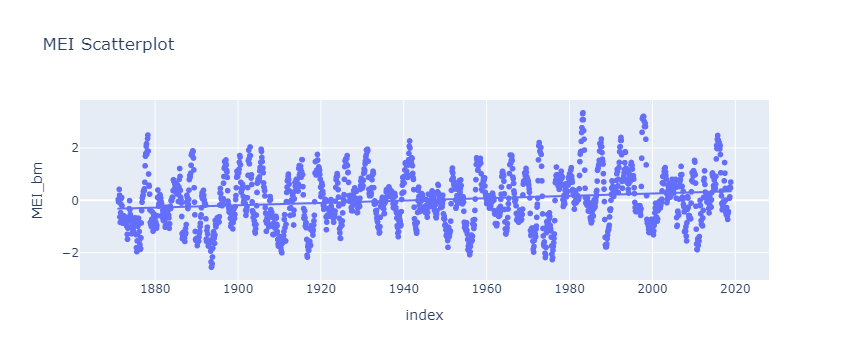

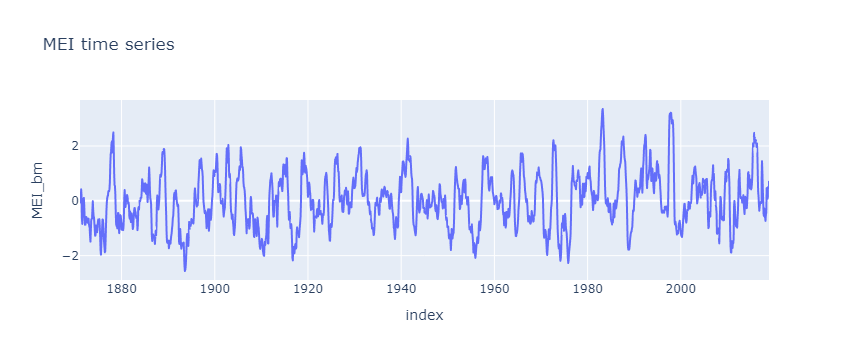

In [2]:
import plotly.express as px

Xt_scatterplot = px.scatter(Xt, title='MEI Scatterplot', y='MEI_bm', trendline='ols') # Scatterplot
Xt_lineplot = px.line(Xt, title='MEI time series', y='MEI_bm')                        # Lineplot

Xt_scatterplot.show()
Xt_lineplot.show()

## Analysis of the Series for Stationarity

### Histogram, Q-Qplot and Autocorrelation Plot

Given the behavior observed in the previous graphs, a histogram is constructed to search for a normal distribution. Likewise, a Q-Q plot is created to compare the quantiles of the empirical distribution of MEI_bm with a normal distribution.

In the *histogram*, we can observe that the data of the MEI_bm variable has a slight right skew, that is, there are more observations with high values than observations with low values. Additionally, the trend line of the histogram resembles that of a normal distribution.

In the *Q-Q plot*, extreme values are shown not very far from the diagonal, but not significantly so. Furthermore, the central values fit very well to the diagonal, suggesting that the data follows a normal distribution.

Finally, an *autocorrelation plot* of the time series is created, considering 50 lags. In this graph, we can observe a gradual decay of the data, where at lag 12 there seems to be a significant level of correlation with at least 12 of the immediately preceding observations, that is, the MEI_bm observations from an entire previous year seem to have a significant impact on the current ones. In terms of stationarity, the autocorrelation plot seems to indicate a non-stationary series.


Sample mean: 0.013

Variance: 0.988

Standard deviation: 0.994



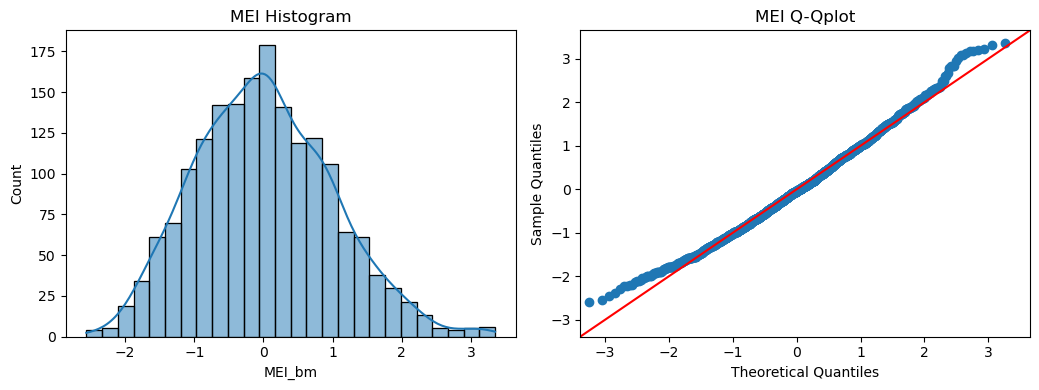

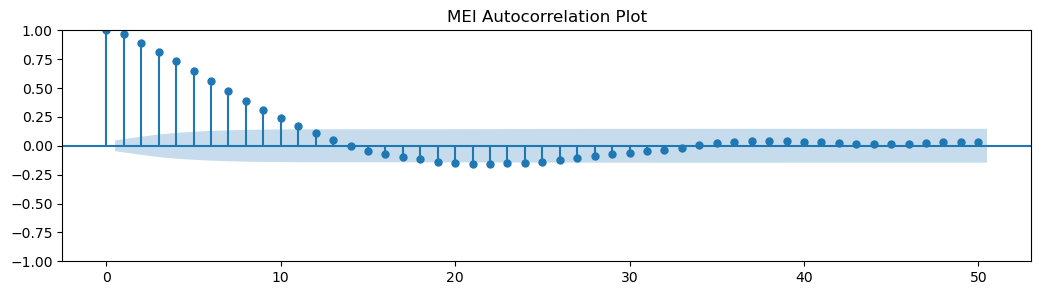

In [3]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

MEI_bm_Xt = Xt['MEI_bm']

#-----------------------------------------Descriptive statistics-----------------------------------------------------------------------
print(f'\nSample mean: {MEI_bm_Xt.mean():.3f}')
print(f'\nVariance: {MEI_bm_Xt.var():.3f}')
print(f'\nStandard deviation: {MEI_bm_Xt.std():.3f}\n')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------Histogram and QQplot--------------------------------------------------------------------------
_, ax = plt.subplots(1, 2, figsize=(10.5, 4))

ax[0].set_title('MEI Histogram')
sns.histplot(MEI_bm_Xt, kde=True, ax=ax[0])

ax[1].set_title('MEI Q-Qplot')
sm.qqplot(MEI_bm_Xt, fit=True, line='45', loc=MEI_bm_Xt.mean(), ax=ax[1])

plt.tight_layout()
plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Autocorrelation plot
_, ax = plt.subplots(figsize=(12.5,3))
MEI_bm_Xt_acf = plot_acf(MEI_bm_Xt, title='MEI Autocorrelation Plot', ax=ax, lags=50)
plt.show()

### Augmented Dickey-Fuller Test

Given that no clear evidence of the series' stationarity was found in the previous graphs, an Augmented Dickey-Fuller (ADF) test is performed to make a decision about the stationarity of the series. For this test, the following hypotheses are considered:

* $H_0$: The series is non-stationary.
* $H_1$: The series is stationary.

considering a significance level of $\alpha=0.05$, where $H_0$ represents the null hypothesis and $H_1$ the alternative hypothesis. The test results show a p-value of 0.000 which is less than $\alpha$. Therefore, the null hypothesis is rejected, that is, it is concluded that the series is stationary.

In [4]:
from statsmodels.tsa.stattools import adfuller

ADF_Xt = adfuller(MEI_bm_Xt)

print(f'\nADF statistic: {ADF_Xt[0]:.3f}')
print(f'\np-value: {ADF_Xt[1]:.3f}')


ADF statistic: -8.782

p-value: 0.000


## Data Modeling

Given the time series is stationary, an ARMA(p,q) model will be implemented as a first option to forecast the MEI. However, the slow decay of the autocorrelation function presented earlier suggests that a differencing process may be appropriate for the series. Therefore, an ARIMA(p,1,q) model will also be implemented and appropriate comparisons will be made to evaluate the efficiency of both models.

We will start by dividing the dataset into training and validation sets, with an 80-20 split. Subsequently, we will analyze the correlograms of the autocorrelation and partial autocorrelation functions to obtain the optimal values for the AR(p) and MA(q) components in the corresponding models.

### Comparison of the first-differenced series

In the scatterplot of the first difference of the series (identified as `diff_1`), we can observe that the slope of the trend line has decreased.

Subsequently, an **ADF test** was applied with a significance level of $\alpha=0.05$, where a p-value of 0.000 was obtained, which is less than α. Therefore, the null hypothesis for `diff_1` is rejected, meaning that the series remains stationary after the first difference.

Additionally, we can observe that the autocorrelation decays significantly faster after the first difference, in which only the first two values appear to be significant. While an abrupt decay can be indicative of over-differencing, the efficiency between the model corresponding to the differenced series and the model corresponding to the original series will be evaluated later.

Finally, in the line plot, we can see that the variation of the data over time has been significantly reduced by differencing the series. In terms of modeling, the resulting model may not capture the necessary variation to make accurate predictions.


ADF statistic: -11.355

p-value: 0.000



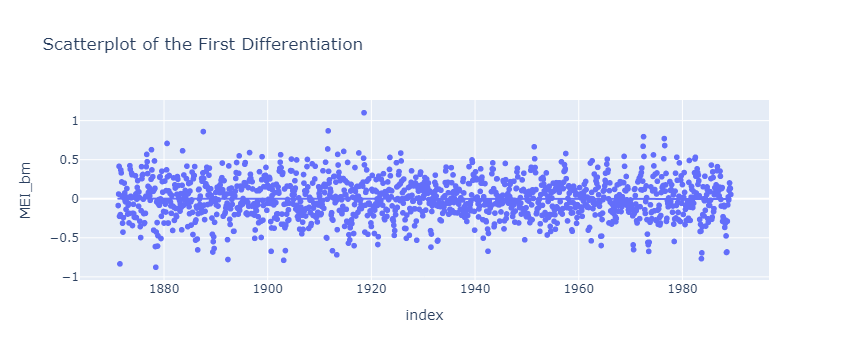

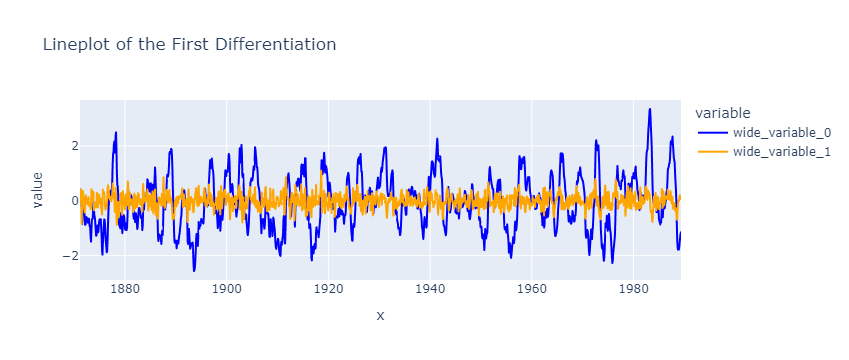

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(Xt, test_size=0.2, shuffle=False) 
diff_1 = train.diff().dropna()                                   # First differentiation

#--------------------------------------------------------Scatterplot and lineplot------------------------------------------------------------------------
diff_1_scatter = px.scatter(diff_1, trendline='ols', title='Scatterplot of the First Differentiation', y='MEI_bm') # Scatterplot
diff_1_lineplot = px.line(y=[train['MEI_bm'][1:], diff_1['MEI_bm']], x=diff_1.index, color_discrete_sequence=['blue', 'orange'],
                         title='Lineplot of the First Differentiation')   # Lineplot
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Augmented Dickey-Fuller test
ADF_diff_1 = adfuller(diff_1)
print(f'\nADF statistic: {ADF_diff_1[0]:.3f}')
print(f'\np-value: {ADF_diff_1[1]:.3f}\n')

diff_1_scatter.show()
diff_1_lineplot.show()

### Estimation of AR and MA parameters

By carefully examining the autocorrelation and partial autocorrelation plots associated with `MEI_bm`, we observe that:

* The first 12 lags of autocorrelation are notably significant.
* The first 8 lags of partial autocorrelation are notably significant.

Therefore, we expect values of $p$=1,…,8 and $q$=1,…,12 for an ARMA$(p,q)$ model to adequately explain the behavior of the MEI. On the other hand, when analyzing the autocorrelation and partial autocorrelation plots associated with `diff_1`, we observe that:

* The first 2 lags of autocorrelation are notably significant.
* The first 10 lags of partial autocorrelation are notably significant.

Therefore, we expect values of $p$=1,…,10 and $q$=1,2 for an ARIMA(p,1,q) model to adequately explain the behavior of the MEI.

### Model Selection Criteria

To evaluate the efficiency of the models based on the values of p and q, we will consider the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC), taking the values of $p$ and $q$ that minimize these criteria. For the ARMA model, a classical approach will be adopted where each of the possible values of $p$ and $q$ is evaluated. In contrast, for the ARIMA model, the auto_arima function will be used, which finds the optimal values for $p$ and $q$ with respect to the specified criterion.

Model Selection Results
The results of training the different models show that the following models are optimal with respect to the established parameters:

* ARMA(4, 2) for both minimum AIC and BIC.
* ARIMA(2, 1, 5) for minimum AIC.
* ARIMA(0, 1, 3) for minimum BIC.

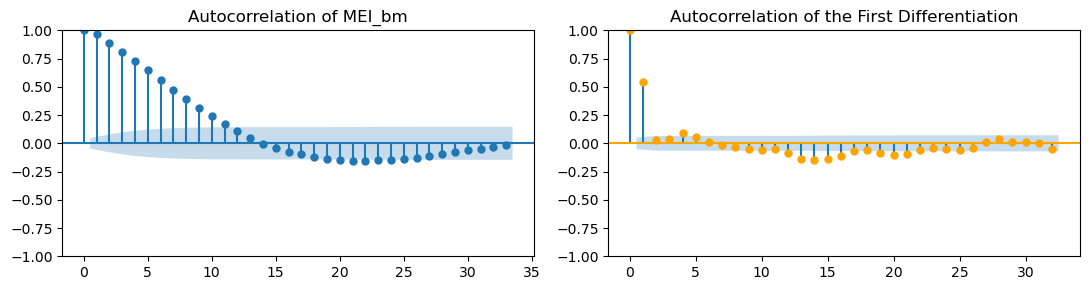

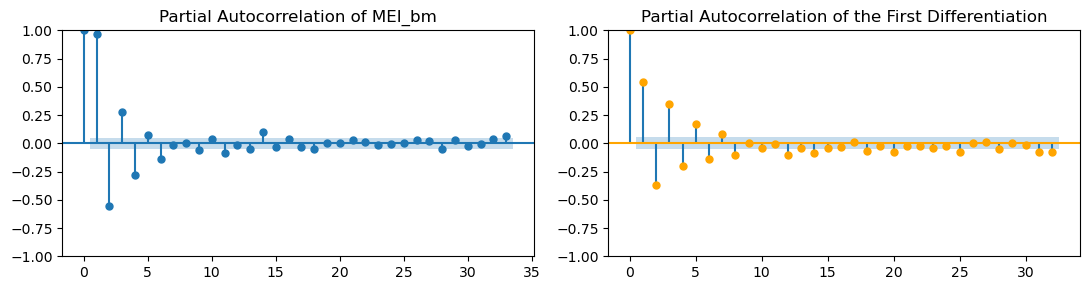

In [6]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

#------------------------------------------------------Comparing autocorrelation and partial autocorrelation-------------------------------------------------------

_, ax = plt.subplots(1, 2, figsize=(11,3)) # Autocorrelation
MEI_bm_Xt_acf = plot_acf(MEI_bm_Xt, title='Autocorrelation of MEI_bm', ax=ax[0])
diff_1_acf = plot_acf(diff_1, title='Autocorrelation of the First Differentiation', ax=ax[1], color='orange')

plt.tight_layout()
plt.show()

_, ax = plt.subplots(1, 2, figsize=(11,3)) # Partial autocorrelation
MEI_bm_Xt_pacf = plot_pacf(MEI_bm_Xt, title='Partial Autocorrelation of MEI_bm', ax=ax[0])
diff_1_pacf = plot_pacf(diff_1, title='Partial Autocorrelation of the First Differentiation', ax=ax[1], color='orange')

plt.tight_layout() 
plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

AIC_values = []
BIC_values = []

In [7]:
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)

for p in range(1, 8):       # Consider p values in range(1,8). If the process is too slow -> p in range(1,5)
    for q in range(1, 3):   # Consider p values in range(1,3). If the process is too slow -> p in range(1,3)
        modelo_MEI_bm = ARIMA(train, order=(p, 0, q)).fit()
        AIC_values.append((p, q, modelo_MEI_bm.aic))
        BIC_values.append((p, q, modelo_MEI_bm.bic))

In [8]:
# Identify p and q minimum values according to AIC and BIC respectively
AIC = min(AIC_values, key=lambda x: x[2])
BIC = min(BIC_values, key=lambda x: x[2])

print(f'\nBest values according to AIC are p={AIC[0]} and q={AIC[1]}')
print(f'\nBest values according to BIC are p={BIC[0]} and q={BIC[1]}')


Best values according to AIC are p=4 and q=2

Best values according to BIC are p=4 and q=2


In [9]:
model_MEI_bm = ARIMA(train, order=(4, 0, 2)).fit()    # Train the ARMA(4,2) model

In [10]:
from pmdarima import auto_arima
# Train the ARIMA(p, 1, q) model minimizing AIC
auto_model_MEI_bm_aic = auto_arima(train, 
                                    d=1,  # Considering one diferentiation
                                    information_criterion='aic',
                                    seasonal=12,
                                    trace=False, 
                                    stepwise=True)

In [11]:
# Train the ARIMA(p, 1, q) model minimizing AIC
auto_model_MEI_bm_bic = auto_arima(train,
                                   d=1,  # Considering one diferentiation
                                   information_criterion='bic',
                                   seasonal=12,
                                   trace=False,
                                   stepwise=True)

### Analysis of residuals

To validate the models, it is crucial to examine the residual patterns. Ideally, the residuals should exhibit white noise characteristics, implying:
* No autocorrelation
* Zero mean
* Constant variance
If these assumptions are violated, more sophisticated noise modeling techniques would be required, which are beyond the scope of this paper.

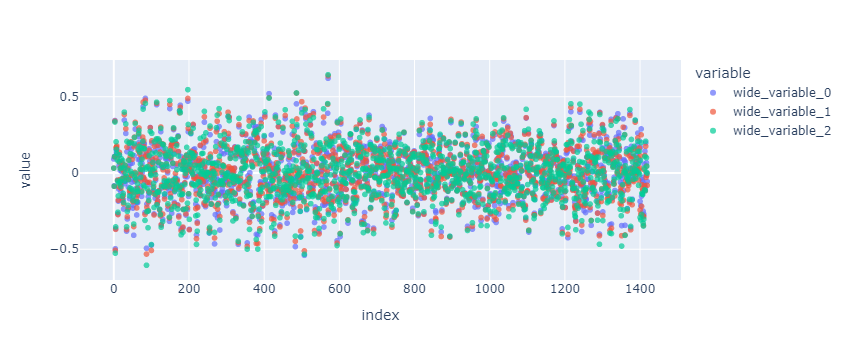

In [12]:
# Residuals computation
residuals_MEI_bm = model_MEI_bm.resid
residuals_aic = auto_model_MEI_bm_aic.resid()
residuals_bic = auto_model_MEI_bm_bic.resid()

# Residuals visualization 
opacities = [0.7] * (len(residuals_MEI_bm) + len(residuals_aic) + len(residuals_bic))
residuals_MEI_bm_scatter = px.scatter(y=[residuals_MEI_bm, residuals_aic, residuals_bic], opacity=opacities)
residuals_MEI_bm_scatter.show()

#### Ljung-Box Test

To confirm that there is no significant autocorrelation in the residuals, we will use the Ljung-Box test, setting up the following hypotheses:
* $H_0$: There is no autocorrelation in the residuals.
* $H_1$: There is autocorrelation in the residuals.
  
Considering a significance level of $\alpha$=0.05 and up to 12 lags (one year), we obtain the following results:
* All $p$-values for the ARMA model are significantly greater than $\alpha$.
* All $p$-values for the ARIMA(2,1,5) model are significantly greater than $\alpha$.
* All $p$-values for the ARIMA(0,1,3) model are greater than α only for the first 12 periods.

Therefore, the null hypothesis is not rejected for the ARMA and ARIMA(2,1,5) models. For the ARIMA(0,1,3) model, the null hypothesis is not rejected for the first 12 lags, however, there is evidence of autocorrelation in the residuals after 12 lags, which may cause errors in the predictions of the corresponding model.

#### Jarque-Bera Test

Using descriptive statistics, a comparative histogram, and a Q-Q plot, we can observe that the residuals of the different models resemble a normal distribution $N$(0,0.3). However, since this is not sufficient to conclude that these residuals actually come from a normal distribution, we performed a Jarque-Bera normality test, in which we set up the following hypotheses:
* $H_0$: The residuals follow a normal distribution.
* $H_1$: The residuals do not follow a normal distribution.
  
Where $H_0$ is the null hypothesis, $H_1$ is the alternative hypothesis, and a significance level of $\alpha$=0.05 is considered. The test results are as follows:
* The $p$-value of the test applied to the ARMA model is 0.867.
* The $p$-value of the test applied to the ARIMA(2,1,5) model is 0.513.
* The $p$-value of the test applied to the ARIMA(0,1,3) model is 0.369.
  
In all three cases, we can observe that the calculated p-value is greater than $\alpha$, so in none of the cases is the null hypothesis rejected. Therefore, there is no significant evidence to say that the residuals do not follow a normal distribution.


ARMA model residuals mean 0.000

ARIMA(2,1,5) model residuals mean 0.000

ARIMA(0,1,3) model residuals mean -0.000

ARMA model residuals variance 0.029

ARIMA(2,1,5) model residuals variance 0.030

ARIMA(0,1,3) model residuals variance 0.031

ARMA model p-values 0.867

ARIMA(2,1,5) model p-value 0.513

ARIMA(0,1,3) model p-value 0.369



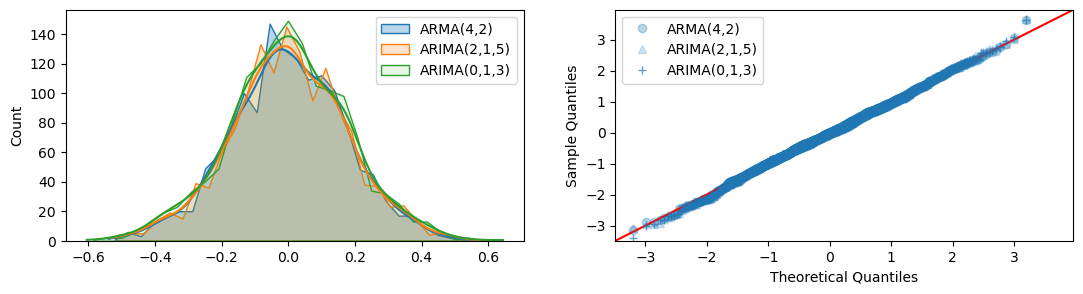

In [13]:
from statsmodels.stats.api import jarque_bera

# Mean of the residuals
print(f'\nARMA model residuals mean {residuals_MEI_bm.mean():.3f}')
print(f'\nARIMA(2,1,5) model residuals mean {residuals_aic.mean():.3f}')
print(f'\nARIMA(0,1,3) model residuals mean {residuals_bic.mean():.3f}')

# Variance of the residuals
print(f'\nARMA model residuals variance {residuals_MEI_bm.var():.3f}')
print(f'\nARIMA(2,1,5) model residuals variance {residuals_aic.var():.3f}')
print(f'\nARIMA(0,1,3) model residuals variance {residuals_bic.var():.3f}')

# Jarque-Bera p-values
print(f'\nARMA model p-values {jarque_bera(residuals_MEI_bm)[1]:.3}')
print(f'\nARIMA(2,1,5) model p-value {jarque_bera(residuals_aic)[1]:.3}')
print(f'\nARIMA(0,1,3) model p-value {jarque_bera(residuals_bic)[1]:.3}\n')

#---------------------------------------------------------------Residuals histogram and QQplot--------------------------------------------------------------------------

# Histogram
_, ax = plt.subplots(1, 2, figsize=(13, 3))
sns.histplot(residuals_MEI_bm, kde=True, alpha=0.3, element='poly',  bins=30, ax=ax[0], label='ARMA(4,2)')
sns.histplot(residuals_aic, kde=True, alpha=0.2, element='poly',  bins=30, ax=ax[0], label='ARIMA(2,1,5)')
sns.histplot(residuals_bic, kde=True, alpha=0.1, element='poly',  bins=30, ax=ax[0], label='ARIMA(0,1,3)')
ax[0].legend()

# Q-Qplot
sm.qqplot(residuals_MEI_bm, fit=True, line='45', loc=residuals_MEI_bm.mean(), alpha=0.3, label='ARMA(4,2)', ax=ax[1])
sm.qqplot(residuals_aic, fit=True, alpha=0.2, color='orange', label='ARIMA(2,1,5)', marker='^', ax=ax[1])
sm.qqplot(residuals_bic, fit=True, alpha=0.7, color='green', label='ARIMA(0,1,3)', marker='+', ax=ax[1])
ax[1].legend()

plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Breusch-Pagan Test

Finally, we will check if the variance of the residuals is constant, that is, we will verify the existence of homoscedasticity. To do this, we will use the Breusch-Pagan test for heteroscedasticity, where the following hypotheses are stated:
* $H_0$: There is no heteroscedasticity in the residuals.
* $H_1$: There is heteroscedasticity in the residuals.
  
Where $H_0$ denotes the null hypothesis, $H_1$ the alternative hypothesis, and a significance level of $\alpha$=0.05 is considered. The following results were obtained:
* The p-value of the test applied to the ARMA model is 0.001.
* The p-value of the test applied to the ARIMA(2,1,5) model is 0.001.
* The p-value of the test applied to the ARIMA(0,1,3) model is 0.005.

We can observe that in all three cases the p-value of the test is less than $\alpha$, so in all cases the null hypothesis is rejected. Therefore, there is significant evidence to consider that the residuals of the models exhibit heteroscedasticity, which could present problems in the application of the model.

In [14]:
from statsmodels.stats.diagnostic import het_breuschpagan
from numpy import arange
import statsmodels.api as sm

X = sm.add_constant(arange(len(residuals_aic)))

print(f'ARMA model p-value {het_breuschpagan(residuals_MEI_bm, X)[1]:.3f}')
print(f'ARIMA(2,1,5) model p-value {het_breuschpagan(residuals_aic, X)[1]:.3f}')
print(f'ARIMA(0,1,3) model p-value {het_breuschpagan(residuals_bic, X)[1]:.3f}')

ARMA model p-value 0.001
ARIMA(2,1,5) model p-value 0.001
ARIMA(0,1,3) model p-value 0.005


In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

print(f'\nARMA(4,2) p-values\n {acorr_ljungbox(residuals_MEI_bm, lags=24)}')
print(f'\nARIMA(2,1,5) p-values\n {acorr_ljungbox(residuals_aic, lags=24)}')
print(f'\nARIMA(0,1,3) p-values\n {acorr_ljungbox(residuals_bic, lags=24)}')


ARMA(4,2) p-values
       lb_stat  lb_pvalue
1    0.006318   0.936647
2    0.019378   0.990358
3    0.100662   0.991758
4    0.166143   0.996735
5    0.411301   0.995013
6    0.784912   0.992472
7    1.083809   0.993361
8    1.427019   0.993854
9    1.537958   0.996855
10   1.678543   0.998263
11   4.550623   0.950966
12   4.551677   0.971305
13   5.404356   0.965181
14   7.064315   0.932204
15   7.100601   0.954798
16   7.919688   0.951221
17   9.617521   0.918879
18  11.390499   0.877057
19  12.062151   0.882952
20  12.291474   0.905678
21  14.260659   0.858145
22  14.883658   0.867182
23  14.884971   0.898709
24  14.926561   0.922889

ARIMA(2,1,5) p-values
       lb_stat  lb_pvalue
1    0.010576   0.918090
2    0.018332   0.990876
3    1.529347   0.675514
4    1.593371   0.809983
5    1.594629   0.901898
6    2.256757   0.894636
7    2.261419   0.943967
8    2.459786   0.963580
9    2.781751   0.972323
10   4.147390   0.940453
11   6.852393   0.810908
12   7.679650   0.809637
13   

## Predictions

### Long-term predictions using the ARMA model

We can observe that the model fits the training data well. However, predictions of data unknown to the model do not fit well with the observations, as they are not within the model's confidence interval, and both graphs are noticeably different in the prediction interval (after the red line).

The total calculated errors are:
* Mean Absolute Error (MAE): 0.27
* Mean Squared Error (MSE): 0.25
* Root Mean Squared Error (RMSE): 0.5
  
While the errors considering only the predictions are:
* Mean Absolute Error (MAE): 0.8
* Mean Squared Error (MSE): 1.1
* Root Mean Squared Error (RMSE): 1.06


model MAE: 0.27

model MSE: 0.25

model RMSE: 0.50

predictions MAE: 0.80

predictions MSE: 1.12

predictions RMSE: 1.06



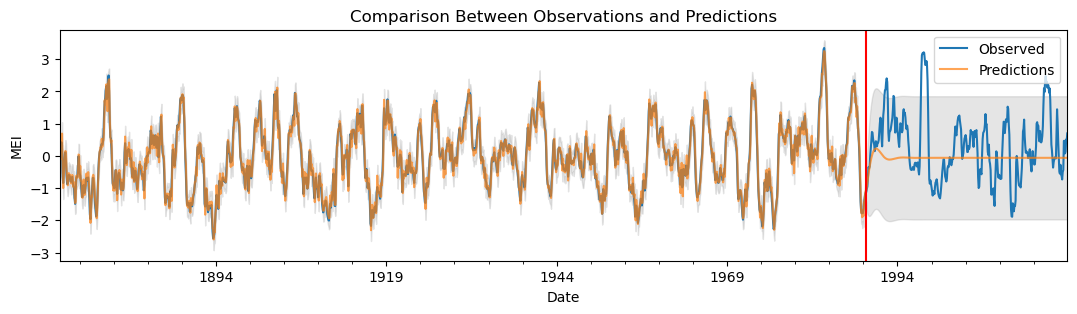

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#-------------------------------------------Predictions and its confidence intervals using ARMA(4,2) model-------------------------------------------
predictions_MEI = model_MEI_bm.get_prediction(start=MEI_bm_Xt.index[0], end=MEI_bm_Xt.index[-1])
y_pred = predictions_MEI.predicted_mean
confidence_intervals = predictions_MEI.conf_int()
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------Predictions and its confidence intervals visualization------------------------------------------------------
ax = MEI_bm_Xt.plot(label='Observed', figsize=(13, 3), title='Comparison Between Observations and Predictions')
y_pred.plot(ax=ax, label='Predictions', alpha=0.7)
ax.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.2) # confidence intervals
ax.set_xlabel('Date')
ax.set_ylabel('MEI')
plt.legend()

pred_index = train.index[-1]
plt.axvline(x=pred_index, color='red') # Vertical line where test data starts
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------Total error of the model---------------------------------------------------------------------------
MAE_total_MEI = mean_absolute_error(MEI_bm_Xt, y_pred)
MSE_total_MEI = mean_squared_error(MEI_bm_Xt, y_pred)
RMSE_total_MEI = np.sqrt(MSE_total_MEI)

print(f'\nmodel MAE: {MAE_total_MEI:.2f}')
print(f'\nmodel MSE: {MSE_total_MEI:.2f}')
print(f'\nmodel RMSE: {RMSE_total_MEI:.2f}')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------Errores en las predicciones--------------------------------------------------------------------------
MAE_pred_MEI = mean_absolute_error(MEI_bm_Xt[pred_index:], y_pred[pred_index:])
MSE_pred_MEI = mean_squared_error(MEI_bm_Xt[pred_index:], y_pred[pred_index:])
RMSE_pred_MEI = np.sqrt(MSE_pred_MEI)

print(f'\npredictions MAE: {MAE_pred_MEI:.2f}')
print(f'\npredictions MSE: {MSE_pred_MEI:.2f}')
print(f'\npredictions RMSE: {RMSE_pred_MEI:.2f}\n')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.show()

### Long-term predictions using the ARIMA models

We can observe that the behavior of the ARIMA(2,1,5) model is similar to the ARMA model, where the confidence interval encompasses the actual data more effectively. For this model, we have calculated the following total errors:
* MAE = 0.27
* MSE = 0.24
* RMSE = 0.49
  
Then, the errors in the predictions of the ARIMA(2,1,5) model are:
* MAE = 0.79
* MSE = 1.07
* RMSE = 1.03
  
Note that the prediction error is quite similar to that of the ARMA model. On the other hand, the ARIMA(0,1,3) model presents a rather inaccurate graph, and we have the following metrics:
* MAE = 0.41
* MSE = 0.65
* RMSE = 0.81
  
These total errors are significantly higher compared to the previous models. Finally, the errors in the predictions of the ARIMA(0,1,3) model are:
* MAE = 1.48
* MSE = 3.11
* RMSE = 1.76
  
These are significantly higher compared to the previous models.


MAE, MSE, RMSE of the ARIMA(2,1,5) model: 0.27, 0.24, 0.49

MAE, MSE, RMSE of the ARIMA(0,1,3) model: 0.41, 0.65, 0.81

MAE, MSE, RMSE of the ARIMA(2,1,5) model predictions: 0.79, 1.07, 1.03

MAE, MSE, RMSE fo the ARIMA(0,1,3) model predictions: 1.48, 3.11, 1.76



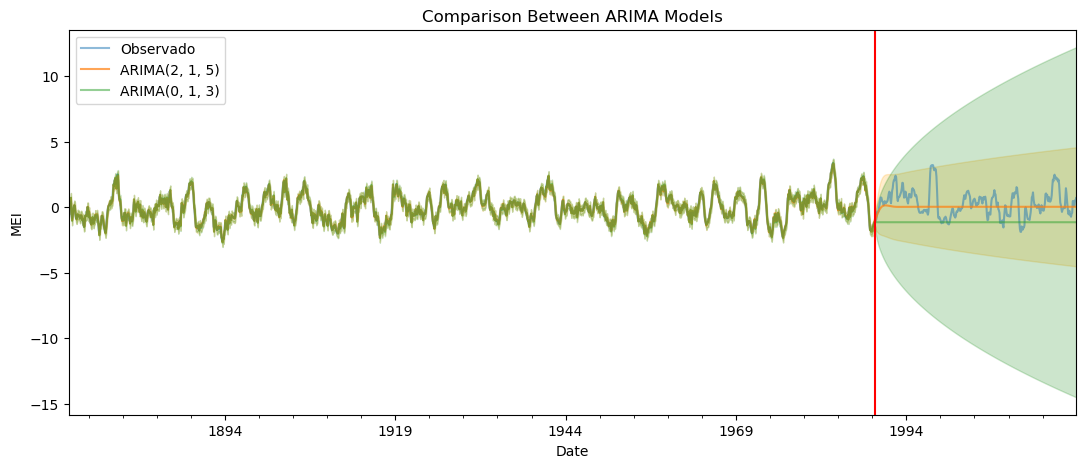

In [17]:
#--------------------------------------------------Predicctions and its confidence intervals-----------------------------------------------------------------------------------
auto_aic_pred_in, confidence_intervals_aic_in = auto_model_MEI_bm_aic.predict_in_sample(return_conf_int=True)
auto_bic_pred_in, confidence_intervals_bic_in = auto_model_MEI_bm_bic.predict_in_sample(return_conf_int=True)

n_periods = len(MEI_bm_Xt) - len(train) # Number of periods to predict

auto_aic_pred_out, confidence_intervals_aic_out = auto_model_MEI_bm_aic.predict(return_conf_int=True, n_periods=n_periods)
auto_bic_pred_out, confidence_intervals_bic_out = auto_model_MEI_bm_bic.predict(return_conf_int=True, n_periods=n_periods)
#----------------------------------------------------------------------------------------------------------------------------------------------------------------
# We join the predictions into a global prediction
auto_aic_pred = pd.concat([auto_aic_pred_in, auto_aic_pred_out])
auto_bic_pred = pd.concat([auto_bic_pred_in, auto_bic_pred_out])

# We join the confidence intervals to graph them
confidence_intervals_aic = np.concatenate((confidence_intervals_aic_in, confidence_intervals_aic_out))
confidence_intervals_bic = np.concatenate((confidence_intervals_bic_in, confidence_intervals_bic_out))

# We convert the arrays into DataFrames
confidence_intervals_aic = pd.DataFrame(confidence_intervals_aic, index=MEI_bm_Xt.index)[1:]
confidence_intervals_bic = pd.DataFrame(confidence_intervals_bic, index=MEI_bm_Xt.index)[1:]

#-------------------------------------------Values and predictions visualization-----------------------------------------------------------------------------
ax = MEI_bm_Xt.plot(label='Observado', figsize=(13, 5), title='Comparison Between ARIMA Models', alpha=0.5)
auto_aic_pred.plot(ax=ax, label='ARIMA(2, 1, 5)', alpha=0.7)
auto_bic_pred.plot(ax=ax, label='ARIMA(0, 1, 3)', alpha=0.5)
ax.fill_between(confidence_intervals_aic.index, confidence_intervals_aic.iloc[:, 0], confidence_intervals_aic.iloc[:, 1], color='orange', alpha=0.2)
ax.fill_between(confidence_intervals_bic.index, confidence_intervals_bic.iloc[:, 0], confidence_intervals_bic.iloc[:, 1], color='green', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('MEI')
plt.legend()
plt.axvline(train.index[-1], color='red')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------Total errors of both models------------------------------------------------------------------------
# ARIMA(2,1,5) total errrors
MAE_total_aic = mean_absolute_error(MEI_bm_Xt, auto_aic_pred)
MSE_total_aic = mean_squared_error(MEI_bm_Xt, auto_aic_pred)
RMSE_total_aic = np.sqrt(MSE_total_aic)

# ARIMA(0,1,3) total errors
MAE_total_bic = mean_absolute_error(MEI_bm_Xt, auto_bic_pred)
MSE_total_bic = mean_squared_error(MEI_bm_Xt, auto_bic_pred)
RMSE_total_bic = np.sqrt(MSE_total_bic)

print(f'\nMAE, MSE, RMSE of the ARIMA(2,1,5) model: {MAE_total_aic:.2f}, {MSE_total_aic:.2f}, {RMSE_total_aic:.2f}')
print(f'\nMAE, MSE, RMSE of the ARIMA(0,1,3) model: {MAE_total_bic:.2f}, {MSE_total_bic:.2f}, {RMSE_total_bic:.2f}')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------Errores en las predicciones de ambos modelos----------------------------------------------------------------
# ARIMA(2,1,5) prediction errors
MAE_pred_aic = mean_absolute_error(MEI_bm_Xt[pred_index:], auto_aic_pred[pred_index:])
MSE_pred_aic = mean_squared_error(MEI_bm_Xt[pred_index:], auto_aic_pred[pred_index:])
RMSE_pred_aic = np.sqrt(MSE_pred_aic)

# ARIMA(0,1,3) prediction errors
MAE_pred_bic = mean_absolute_error(MEI_bm_Xt[pred_index:], auto_bic_pred[pred_index:])
MSE_pred_bic = mean_squared_error(MEI_bm_Xt[pred_index:], auto_bic_pred[pred_index:])
RMSE_pred_bic = np.sqrt(MSE_pred_bic)

print(f'\nMAE, MSE, RMSE of the ARIMA(2,1,5) model predictions: {MAE_pred_aic:.2f}, {MSE_pred_aic:.2f}, {RMSE_pred_aic:.2f}')
print(f'\nMAE, MSE, RMSE fo the ARIMA(0,1,3) model predictions: {MAE_pred_bic:.2f}, {MSE_pred_bic:.2f}, {RMSE_pred_bic:.2f}\n')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.show()

### Short-term Predictions

Given that ARMA/ARIMA models consider both recent and past data, we will opt to make short-term predictions using the models we have already fitted, that is, we will consider all the data in the time series to make the prediction.

Considering a prediction of approximately two years, we can observe that the ARMA(4,2) and ARIMA(2,1,5) models fit the real data well during the first year, while the ARIMA(0,1,3) model does not show any match with the real data. Comparing the metrics of the three models, we obtain:
* Total errors of the ARMA model: MAE = 0.238, MSE = 0.098, RMSE = 0.314
* Total errors of the ARIMA(2,1,5) model: MAE = 0.278, MSE = 0.125, RMSE = 0.353
* Total errors of the ARIMA(0,1,3) model: MAE = 1.196, MSE = 1.786, RMSE = 1.336
  
While for the prediction errors, we have:
* Prediction errors of the ARMA model: MAE = 0.238, MSE = 0.098, RMSE = 0.314
* Prediction errors of the ARIMA(2,1,5) model: MAE = 0.278, MSE = 0.125, RMSE = 0.353
* Prediction errors of the ARIMA(0,1,3): MAE = 1.196, MSE = 1.786, RMSE = 1.336
  
We can observe that the errors of the ARIMA(0,1,3) model are very large compared to the other models, while the errors of the ARMA(4,2) and ARIMA(2,1,5) models are similar and considerably low.


ARMA MAE, MSE, RMSE total errors: 0.238, 0.098, 0.314

ARIMA(2,1,5) MAE, MSE, RMSE total errors: 0.278, 0.125, 0.353

ARIMA(0,1,3) MAE, MSE, RMSE total errors: 1.196, 1.786, 1.336

ARMA MAE, MSE, RMSE prediction errors: 0.238, 0.098, 0.314

ARIMA(2,1,5) MAE, MSE, RMSE prediction errors: 0.278, 0.125, 0.353

ARIMA(0,1,3) MAE, MSE, RMSE prediction errors: 1.196, 1.786, 1.336



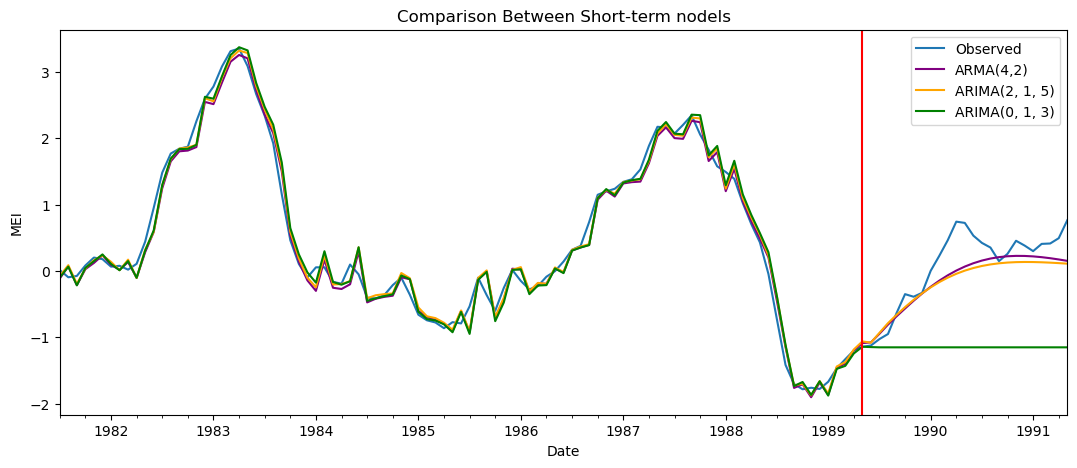

In [18]:
start = int(len(auto_aic_pred_in) - (len(auto_aic_pred_in) / 15))
end = - int(len(auto_aic_pred_out) - (len(auto_aic_pred_out) / 15))

MEI_bm_Xt_short = MEI_bm_Xt[start:end]
y_pred_short = y_pred[start:end]
auto_aic_pred_short = auto_aic_pred[start:end]
auto_bic_pred_short = auto_bic_pred[start:end]

#------------------------------------------------------------Short-term models visualization-----------------------------------------------------------------
ax = MEI_bm_Xt_short.plot(label='Observed', figsize=(13, 5), title='Comparison Between Short-term nodels')
y_pred_short.plot(ax=ax, label='ARMA(4,2)', color='purple')
auto_aic_pred_short.plot(ax=ax, label='ARIMA(2, 1, 5)', color='orange')
auto_bic_pred_short.plot(ax=ax, label='ARIMA(0, 1, 3)', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('MEI')
plt.legend()
plt.axvline(train.index[-1], color='red')
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# ARMA total error
MAE_total_MEI_short = mean_absolute_error(MEI_bm_Xt_short[pred_index:], y_pred_short[pred_index:])
MSE_total_MEI_short = mean_squared_error(MEI_bm_Xt_short[pred_index:], y_pred_short[pred_index:])
RMSE_total_MEI_short = np.sqrt(MSE_total_MEI_short)

# ARIMA(2,1,5) total error
MAE_total_aic_short = mean_absolute_error(MEI_bm_Xt_short[pred_index:], auto_aic_pred_short[pred_index:])
MSE_total_aic_short = mean_squared_error(MEI_bm_Xt_short[pred_index:], auto_aic_pred_short[pred_index:])
RMSE_total_aic_short = np.sqrt(MSE_total_aic_short)

# ARIMA(0,1,3) total error
MAE_total_bic_short = mean_absolute_error(MEI_bm_Xt_short[pred_index:], auto_bic_pred_short[pred_index:])
MSE_total_bic_short = mean_squared_error(MEI_bm_Xt_short[pred_index:], auto_bic_pred_short[pred_index:])
RMSE_total_bic_short = np.sqrt(MSE_total_bic_short)

# ARMA prediction errors
MAE_pred_MEI_short = mean_absolute_error(MEI_bm_Xt_short[pred_index:], y_pred_short[pred_index:])
MSE_pred_MEI_short = mean_squared_error(MEI_bm_Xt_short[pred_index:], y_pred_short[pred_index:])
RMSE_pred_MEI_short = np.sqrt(MSE_pred_MEI_short)

# ARIMA(2,1,5) prediction errors
MAE_pred_aic_short = mean_absolute_error(MEI_bm_Xt_short[pred_index:], auto_aic_pred_short[pred_index:])
MSE_pred_aic_short = mean_squared_error(MEI_bm_Xt_short[pred_index:], auto_aic_pred_short[pred_index:])
RMSE_pred_aic_short = np.sqrt(MSE_pred_aic_short)

# ARIMA(0,1,3) prediction errors
MAE_pred_bic_short = mean_absolute_error(MEI_bm_Xt_short[pred_index:], auto_bic_pred_short[pred_index:])
MSE_pred_bic_short = mean_squared_error(MEI_bm_Xt_short[pred_index:], auto_bic_pred_short[pred_index:])
RMSE_pred_bic_short = np.sqrt(MSE_pred_bic_short)

print(f'\nARMA MAE, MSE, RMSE total errors: {MAE_total_MEI_short:.3f}, {MSE_total_MEI_short:.3f}, {RMSE_total_MEI_short:.3f}')
print(f'\nARIMA(2,1,5) MAE, MSE, RMSE total errors: {MAE_total_aic_short:.3f}, {MSE_total_aic_short:.3f}, {RMSE_total_aic_short:.3f}')
print(f'\nARIMA(0,1,3) MAE, MSE, RMSE total errors: {MAE_total_bic_short:.3f}, {MSE_total_bic_short:.3f}, {RMSE_total_bic_short:.3f}')

print(f'\nARMA MAE, MSE, RMSE prediction errors: {MAE_pred_MEI_short:.3f}, {MSE_pred_MEI_short:.3f}, {RMSE_pred_MEI_short:.3f}')
print(f'\nARIMA(2,1,5) MAE, MSE, RMSE prediction errors: {MAE_pred_aic_short:.3f}, {MSE_pred_aic_short:.3f}, {RMSE_pred_aic_short:.3f}')
print(f'\nARIMA(0,1,3) MAE, MSE, RMSE prediction errors: {MAE_pred_bic_short:.3f}, {MSE_pred_bic_short:.3f}, {RMSE_pred_bic_short:.3f}\n')

## Conclusions

Given the behavior of the models observed throughout this document, we can affirm that the most suitable ARIMA models for predicting the MEI are:

The ARMA(4,2) model with:
* AR(1) = 1.93
* AR(2) = -1.25
* AR(3) = 0.48
* AR(4) = -0.19
* MA(1) = 0.01
* MA(2) = -0.61
  
The ARIMA(2,1,5) model with:
* AR(1) = 1.77
* AR(2) = -0.80
* MA(1) = -0.79
* MA(2) = -0.93
* MA(3) = 0.68
* MA(4) = 0.23
* MA(5) = -0.17
  
Where the ARMA(4,2) model showed a slightly better fit than the ARIMA(2,1,5) model, in addition to not requiring differencing the series. On the other hand, the best ARIMA model according to the BIC is:

The ARIMA(0,1,3) model with:
* MA(1) = 1.03
* MA(2) = 0.09
* MA(3) = -0.08
  
Which does not fit the new data. Therefore, an ARMA(4,2) model with the coefficients shown above is suggested for future predictions of the MEI. However, given that significant evidence of heteroscedasticity was found in the model residuals, it is suggested to analyze models that consider the variation of noise present in the time series and that complement the ARMA(4,2) model to improve prediction. Finally, it is recommended to use the model for predictions in periods no longer than two years given the observations in the predictions made.

In [19]:
print(f'\nARMA autoregressive coefficients {model_MEI_bm.arparams}')
print(f'\nARMA moving average coefficients {model_MEI_bm.maparams}')

print(f'\nARIMA(2,1,5) autoregressive coefficients {auto_model_MEI_bm_aic.arparams()}')
print(f'\nARIMA moving average coefficients(2,1,5) {auto_model_MEI_bm_aic.maparams()}')

print(f'\nARIMA moving average coefficients(0,1,3) {auto_model_MEI_bm_bic.maparams()}')


ARMA autoregressive coefficients [ 1.93918523 -1.25688017  0.48695795 -0.19264845]

ARMA moving average coefficients [ 0.01994152 -0.61548206]

ARIMA(2,1,5) autoregressive coefficients [ 1.7736924  -0.80002482]

ARIMA moving average coefficients(2,1,5) [-0.79143534 -0.93700485  0.68237274  0.23905751 -0.17652123]

ARIMA moving average coefficients(0,1,3) [ 1.03000784  0.09685231 -0.08247319]
